In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import cython
import line_profiler
from typing import Tuple
from cython.parallel import prange

In [2]:
%load_ext Cython

In [3]:
from typing import Tuple

import numpy as np
from numba import njit

from CyRK import nbrk_ode

nbrk_ode_py = nbrk_ode.py_func

In [43]:
@njit()
def y_diff(t, y):
    
    dy = np.zeros_like(y)
    dy[0] = (1. - 0.01 * y[1]) * y[0]
    dy[1] = (0.02 * y[0] - 1.) * y[1]
    
    return dy

@njit()
def y_diff2(t, y, dy):
    
    dy[0] = (1. - 0.01 * y[1]) * y[0]
    dy[1] = (0.02 * y[0] - 1.) * y[1]
    
@njit()
def y_diff3(t, y, dy):
    
    dy[0] = (1. - 0.01 * np.real(y[1])) * np.real(y[0]) + (0.02 * np.imag(y[0]) - 1.) * np.imag(y[1]) * 1j
    dy[1] = (0.02 * np.real(y[0]) - 1.) * np.real(y[1]) + (1. - 0.01 * np.imag(y[1])) * np.imag(y[0]) * 1j
    
@njit()
def y_diff4(t, y):
    
    dy = np.zeros_like(y)
    dy[0] = (1. - 0.01 * np.real(y[1])) * np.real(y[0]) + (0.02 * np.imag(y[0]) - 1.) * np.imag(y[1]) * 1j
    dy[1] = (0.02 * np.real(y[0]) - 1.) * np.real(y[1]) + (1. - 0.01 * np.imag(y[1])) * np.imag(y[0]) * 1j
    return dy

initial_conds = np.asarray((20., 20.), dtype=np.complex128)
initial_conds3 = np.asarray((20. + 20.j, 20. + 20.j), dtype=np.complex128)
time_span = (0., 50.)
rtol = 1.0e-7
atol = 1.0e-8

def diff_plot(t, y):
    
    fig, ax = plt.subplots()
    ax.plot(t, y[0], 'r', label='$y_{0}$')
    ax.plot(t, y[1], 'b', label='$y_{1}$')
    ax.set(xlabel='$t$', ylabel='$y$')
    ax.legend(loc='best')
    
    plt.show()

In [5]:
%%cython --annotate --force
import cython
import numpy as np
cimport numpy as np
from libc.math cimport sqrt
from cpython cimport array

from numpy.core.multiarray import (interp as compiled_interp, interp_complex as compiled_interp_complex
    )

np.import_array()

from libc.math cimport sqrt, fabs

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
cdef double cabs(double complex value) nogil:
    cdef double v_real = value.real
    cdef double v_imag = value.imag
    return sqrt(v_real * v_real + v_imag * v_imag)



complex_type = np.complex128
float_type = np.float64


# Multiply steps computed from asymptotic behaviour of errors by this.
cdef double SAFETY = 0.9

cdef double MIN_FACTOR = 0.2  # Minimum allowed decrease in a step size.
cdef double MAX_FACTOR = 10.  # Maximum allowed increase in a step size.
cdef double MAX_STEP = np.inf
cdef double INF = np.inf

cdef double EPS = np.finfo(np.float64).eps
cdef double EPS_10 = EPS * 10.
cdef double EPS_100 = EPS * 100.


unused_t_eval = np.empty((0,), dtype=np.float64)

# RK23 Constants
cdef double RK23_C[3]
cdef double complex RK23_B[3]
cdef double complex RK23_E[4]
cdef double complex RK23_A[3][3]
cdef unsigned int RK23_order = 3
cdef unsigned int RK23_error_order = 2
cdef unsigned int RK23_n_stages = 3
RK23_C[:] = [0, 1 / 2, 3 / 4]
cdef unsigned int RK23_LEN_C = 3
RK23_B[:] = [2 / 9, 1 / 3, 4 / 9]
RK23_E[:] = [5 / 72, -1 / 12, -1 / 9, 1 / 8]

RK23_A[0][:] = [0, 0, 0]
RK23_A[1][:] = [1 / 2, 0, 0]
RK23_A[2][:] = [0, 3 / 4, 0]

# RK45 Constants
cdef double RK45_C[6]
cdef double complex RK45_B[6]
cdef double complex RK45_E[7]
cdef double complex RK45_A[6][5]
cdef unsigned int RK45_order = 5
cdef unsigned int RK45_error_order = 4
cdef unsigned int RK45_n_stages = 6
RK45_C[:] = [0, 1 / 5, 3 / 10, 4 / 5, 8 / 9, 1]
cdef unsigned int RK45_LEN_C = 6
RK45_B[:] = [35 / 384, 0, 500 / 1113, 125 / 192, -2187 / 6784, 11 / 84]
RK45_E[:] = [-71 / 57600, 0, 71 / 16695, -71 / 1920, 17253 / 339200, -22 / 525, 1 / 40]

RK45_A[0][:] = [0, 0, 0, 0, 0]
RK45_A[1][:] = [1 / 5, 0, 0, 0, 0]
RK45_A[2][:] = [3 / 40, 9 / 40, 0, 0, 0]
RK45_A[3][:] = [44 / 45, -56 / 15, 32 / 9, 0, 0]
RK45_A[4][:] = [19372 / 6561, -25360 / 2187, 64448 / 6561, -212 / 729, 0]
RK45_A[5][:] = [9017 / 3168, -355 / 33, 46732 / 5247, 49 / 176, -5103 / 18656]

# DOP863 Constants

cdef int j_, i_
cdef unsigned int DOP_order = 8
cdef unsigned int DOP_error_order = 7
cdef unsigned int DOP_n_stages = 12
cdef unsigned int DOP_n_stages_extended = 16
cdef double DOP_C[16]
DOP_C = [
    0.0,
    0.526001519587677318785587544488e-01,
    0.789002279381515978178381316732e-01,
    0.118350341907227396726757197510,
    0.281649658092772603273242802490,
    0.333333333333333333333333333333,
    0.25,
    0.307692307692307692307692307692,
    0.651282051282051282051282051282,
    0.6,
    0.857142857142857142857142857142,
    1.0,
    1.0,
    0.1,
    0.2,
    0.777777777777777777777777777778]

cdef double DOP_C_REDUCED[12]
for i_ in range(12):
    DOP_C_REDUCED[i_] = DOP_C[i_]
cdef unsigned int DOP_LEN_C = 12

cdef double complex DOP_A[16][16]
for j_ in range(16):
    for i_ in range(16):
        DOP_A[i_][j_] = 0.

DOP_A[1][0] = 5.26001519587677318785587544488e-2

DOP_A[2][0] = 1.97250569845378994544595329183e-2
DOP_A[2][1] = 5.91751709536136983633785987549e-2

DOP_A[3][0] = 2.95875854768068491816892993775e-2
DOP_A[3][2] = 8.87627564304205475450678981324e-2

DOP_A[4][0] = 2.41365134159266685502369798665e-1
DOP_A[4][2] = -8.84549479328286085344864962717e-1
DOP_A[4][3] = 9.24834003261792003115737966543e-1

DOP_A[5][0] = 3.7037037037037037037037037037e-2
DOP_A[5][3] = 1.70828608729473871279604482173e-1
DOP_A[5][4] = 1.25467687566822425016691814123e-1

DOP_A[6][0] = 3.7109375e-2
DOP_A[6][3] = 1.70252211019544039314978060272e-1
DOP_A[6][4] = 6.02165389804559606850219397283e-2
DOP_A[6][5] = -1.7578125e-2

DOP_A[7][0] = 3.70920001185047927108779319836e-2
DOP_A[7][3] = 1.70383925712239993810214054705e-1
DOP_A[7][4] = 1.07262030446373284651809199168e-1
DOP_A[7][5] = -1.53194377486244017527936158236e-2
DOP_A[7][6] = 8.27378916381402288758473766002e-3

DOP_A[8][0] = 6.24110958716075717114429577812e-1
DOP_A[8][3] = -3.36089262944694129406857109825
DOP_A[8][4] = -8.68219346841726006818189891453e-1
DOP_A[8][5] = 2.75920996994467083049415600797e1
DOP_A[8][6] = 2.01540675504778934086186788979e1
DOP_A[8][7] = -4.34898841810699588477366255144e1

DOP_A[9][0] = 4.77662536438264365890433908527e-1
DOP_A[9][3] = -2.48811461997166764192642586468
DOP_A[9][4] = -5.90290826836842996371446475743e-1
DOP_A[9][5] = 2.12300514481811942347288949897e1
DOP_A[9][6] = 1.52792336328824235832596922938e1
DOP_A[9][7] = -3.32882109689848629194453265587e1
DOP_A[9][8] = -2.03312017085086261358222928593e-2

DOP_A[10][0] = -9.3714243008598732571704021658e-1
DOP_A[10][3] = 5.18637242884406370830023853209
DOP_A[10][4] = 1.09143734899672957818500254654
DOP_A[10][5] = -8.14978701074692612513997267357
DOP_A[10][6] = -1.85200656599969598641566180701e1
DOP_A[10][7] = 2.27394870993505042818970056734e1
DOP_A[10][8] = 2.49360555267965238987089396762
DOP_A[10][9] = -3.0467644718982195003823669022

DOP_A[11][0] = 2.27331014751653820792359768449
DOP_A[11][3] = -1.05344954667372501984066689879e1
DOP_A[11][4] = -2.00087205822486249909675718444
DOP_A[11][5] = -1.79589318631187989172765950534e1
DOP_A[11][6] = 2.79488845294199600508499808837e1
DOP_A[11][7] = -2.85899827713502369474065508674
DOP_A[11][8] = -8.87285693353062954433549289258
DOP_A[11][9] = 1.23605671757943030647266201528e1
DOP_A[11][10] = 6.43392746015763530355970484046e-1

DOP_A[12][0] = 5.42937341165687622380535766363e-2
DOP_A[12][5] = 4.45031289275240888144113950566
DOP_A[12][6] = 1.89151789931450038304281599044
DOP_A[12][7] = -5.8012039600105847814672114227
DOP_A[12][8] = 3.1116436695781989440891606237e-1
DOP_A[12][9] = -1.52160949662516078556178806805e-1
DOP_A[12][10] = 2.01365400804030348374776537501e-1
DOP_A[12][11] = 4.47106157277725905176885569043e-2

DOP_A[13][0] = 5.61675022830479523392909219681e-2
DOP_A[13][6] = 2.53500210216624811088794765333e-1
DOP_A[13][7] = -2.46239037470802489917441475441e-1
DOP_A[13][8] = -1.24191423263816360469010140626e-1
DOP_A[13][9] = 1.5329179827876569731206322685e-1
DOP_A[13][10] = 8.20105229563468988491666602057e-3
DOP_A[13][11] = 7.56789766054569976138603589584e-3
DOP_A[13][12] = -8.298e-3

DOP_A[14][0] = 3.18346481635021405060768473261e-2
DOP_A[14][5] = 2.83009096723667755288322961402e-2
DOP_A[14][6] = 5.35419883074385676223797384372e-2
DOP_A[14][7] = -5.49237485713909884646569340306e-2
DOP_A[14][10] = -1.08347328697249322858509316994e-4
DOP_A[14][11] = 3.82571090835658412954920192323e-4
DOP_A[14][12] = -3.40465008687404560802977114492e-4
DOP_A[14][13] = 1.41312443674632500278074618366e-1

DOP_A[15][0] = -4.28896301583791923408573538692e-1
DOP_A[15][5] = -4.69762141536116384314449447206
DOP_A[15][6] = 7.68342119606259904184240953878
DOP_A[15][7] = 4.06898981839711007970213554331
DOP_A[15][8] = 3.56727187455281109270669543021e-1
DOP_A[15][12] = -1.39902416515901462129418009734e-3
DOP_A[15][13] = 2.9475147891527723389556272149
DOP_A[15][14] = -9.15095847217987001081870187138

cdef double complex DOP_A_REDUCED[12][12]
for j_ in range(12):
    for i_ in range(12):
        DOP_A_REDUCED[i_][j_] = DOP_A[i_][j_]

cdef double complex DOP_B[12]
for i_ in range(12):
    DOP_B[i_] = DOP_A[12][i_]

cdef double complex DOP_E3[13]
for i_ in range(13):
    if i_ == 12:
        DOP_E3[i_] = 0.
    else:
        DOP_E3[i_] = DOP_B[i_]
DOP_E3[0] -= 0.244094488188976377952755905512
DOP_E3[8] -= 0.733846688281611857341361741547
DOP_E3[11] -= 0.220588235294117647058823529412e-1


cdef double complex DOP_E5[13]
for i_ in range(13):
    DOP_E5[i_] = 0.
DOP_E5[0] = 0.1312004499419488073250102996e-1
DOP_E5[5] = -0.1225156446376204440720569753e+1
DOP_E5[6] = -0.4957589496572501915214079952
DOP_E5[7] = 0.1664377182454986536961530415e+1
DOP_E5[8] = -0.3503288487499736816886487290
DOP_E5[9] = 0.3341791187130174790297318841
DOP_E5[10] = 0.8192320648511571246570742613e-1
DOP_E5[11] = -0.2235530786388629525884427845e-1\



@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
cdef double find_first_step(
    diffeq,
    tuple args,
    double t_old,
    double complex[:] y_old_view,
    double complex[:] dydt_old_view,
    int y_size,
    double y_size_sqrt,
    double direction,
    double error_expo,
    double atol,
    double rtol
    ):
    """
    Select an initial step size based on the differential equation.
    .. [1] E. Hairer, S. P. Norsett G. Wanner, "Solving Ordinary Differential
           Equations I: Nonstiff Problems", Sec. II.4.
    """
    
    # Setup static variables
    cdef double d0, d0_abs, d1, d1_abs, d2, d2_abs
    cdef double scale, h0_direction, t_new, step_size
    cdef int i
    
    # Setup dynamic variables
    cdef np.ndarray[np.complex128_t, ndim=1] y_new, dydt_new
    y_new = np.empty((y_size,), dtype=np.complex128)
    dydt_new = np.empty((y_size,), dtype=np.complex128)
    cdef double complex[:] y_new_view = y_new
    cdef double complex[:] dydt_new_view = dydt_new
    
    # Find the norm for d0 and d1
    d0 = 0.
    d1 = 0.
    for i in range(y_size):
        scale = atol + cabs(y_old_view[i]) * rtol

        d0_abs = cabs(y_old_view[i] / scale)
        d1_abs = cabs(dydt_old_view[i] / scale)
        d0 += (d0_abs * d0_abs)
        d1 += (d1_abs * d1_abs)

    d0 = sqrt(d0) / y_size_sqrt
    d1 = sqrt(d1) / y_size_sqrt

    if d0 < 1.e-5 or d1 < 1.e-5:
        h0 = 1.e-6
    else:
        h0 = 0.01 * d0 / d1

    h0_direction = h0 * direction
    t_new = t_old + h0_direction
    for i in range(y_size):
        y_new[i] = y_old_view[i] + h0_direction * dydt_old_view[i]

    diffeq(
        t_new,
        y_new,
        dydt_new,
        *args
    )

    # Find the norm for d2
    d2 = 0.
    for i in range(y_size):
        # TODO: Should/could we use the new y that was just calculated to find the scale?
        scale = atol + cabs(y_old_view[i]) * rtol
        
        d2_abs = cabs( (dydt_new_view[i] - dydt_old_view[i]) / scale )
        d2 += (d2_abs * d2_abs)

    d2 = sqrt(d2) / (h0 * y_size_sqrt)

    if d1 <= 1.e-15 and d2 <= 1.e-15:
        h1 = max(1.e-6, h0 * 1.e-3)
    else:
        h1 = (0.01 / max(d1, d2))**error_expo

    step_size = min(100. * h0, h1)
    
    return step_size


@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
#@cython.nonecheck(False)
def cyrk_ode(
    diffeq,
    (double, double) t_span,
    np.ndarray[np.complex128_t, ndim=1] y0,
    tuple args = tuple(),
    double rtol = 1.e-6,
    double atol = 1.e-8,
    double max_step = MAX_STEP,
    double first_step = 0.,
    unsigned int rk_method = 1,
    np.ndarray[np.float64_t, ndim=1] t_eval = unused_t_eval
    ):
    """ A Numba-safe Rugge-Kutta Integrator based on Scipy's solve_ivp RK integrator.

    Parameters
    ----------
    diffeq : callable
        An njit-compiled function that defines the derivatives of the problem.
    t_span : Tuple[float, float]
        A tuple of the beginning and end of the integration domain's dependent variables.
    y0 : np.ndarray
        1D array of the initial values of the problem at t_span[0]
    args : tuple = tuple()
        Any additional arguments that are passed to dffeq.
    rtol : float = 1.e-6
        Integration relative tolerance used to determine optimal step size.
    atol : float = 1.e-8
        Integration absolute tolerance used to determine optimal step size.
    max_step : float = np.inf
        Maximum allowed step size.
    first_step : float = None
        Initial step size. If `None`, then the function will attempt to determine an appropriate initial step.
    rk_method : int = 1
        The type of RK method used for integration
            0 = RK23
            1 = RK45
            2 = DOP853
    t_eval : np.ndarray = None
        If provided, then the function will interpolate the integration results to provide them at the
            requested t-steps.

    Returns
    -------
    time_domain : np.ndarray
        The final time domain. This is equal to t_eval if it was provided.
    y_results : np.ndarray
        The solution of the differential equation provided for each time_result.
    success : bool
        Final integration success flag.
    message : str
        Any integration messages, useful if success=False.

    """
    # Load global variables into the function
    global RK23_C, RK23_B, RK23_E, RK23_A
    global RK45_C, RK45_B, RK45_E, RK45_A
    global complex_type, float_type
    
    # Convert inputs into Memoryviews
    cdef double complex[:] y0_view = y0
    cdef double[:] t_eval_view = t_eval
    
    # Determine information from input
    cdef int y_size
    # y-array
    y_size = y0_view.size
    
    # Define static variables
    cdef str message
    cdef (int, int) K_size, result_size, reduced_result_size
    cdef bint success, step_accepted, step_rejected, step_error = False
    cdef int rk_order, error_order, rk_n_stages, rk_n_stages_plus1, len_c, len_t, \
        len_teval, rk_n_stages_extended
    cdef int s, i, j
    cdef int status
    cdef double t_start, t_end, t_delta, t_delta_abs, \
        error_expo, error_norm, error_norm5, error_norm3, error_denom, error_norm3_abs, error_norm5_abs, error_norm_abs, \
        direction, h0_direction, step_size, time_, min_step, step_factor, c, y_size_sqrt, y_size_dbl, scale
    cdef double complex K_scale
    
    # Define dynamic variables
    cdef list time_domain_list, y_results_list
    cdef np.ndarray[np.float64_t, ndim=1] time_domain
    cdef np.ndarray[np.complex128_t, ndim=1] y_new, y_old, y_tmp, dydt_new, dydt_old, \
        diffeq_out, y_result_temp, E_tmp, y_result_timeslice, \
        E3_tmp, E5_tmp
    cdef np.ndarray[np.complex128_t, ndim=2] y_results, y_results_reduced, K
    
    # Define Memoryviews
    cdef double[:] C
    cdef double complex[:]  y_new_view, \
        y_old_view, dydt_new_view, dydt_old_view, y_tmp_view, diffeq_out_view, \
        E_tmp_view, B, E, E3, E5, E3_tmp_view, E5_tmp_view
    cdef double complex[:, :] K_view, y_results_reduced_view, A

    # Clean up and interpret inputs
    # Time Domain
    t_start     = t_span[0]
    t_end       = t_span[1]
    t_delta     = t_end - t_start
    t_delta_abs = fabs(t_delta)
    len_teval   = t_eval_view.size
    y_size_dbl  = <double>y_size
    y_size_sqrt = sqrt(y_size_dbl)
    if t_delta >= 0.:
        direction = 1.
    else:
        direction = -1.

    # Set flags
    success       = False
    step_accepted = False
    step_rejected = False
    step_error    = False

    # Start storing results with the initial conditions
    time_domain_list = [t_start]
    y_results_list = [y0]

    # Initialize arrays
    y_new          = np.empty(
        y_size,
        dtype=complex_type,
        order='C'
    )
    y_old          = np.empty(
        y_size,
        dtype=complex_type,
        order='C'
    )
    dydt_new       = np.empty(
        y_size,
        dtype=complex_type,
        order='C'
    )
    dydt_old       = np.empty(
        y_size,
        dtype=complex_type,
        order='C'
    )
    y_tmp          = np.empty(
        y_size,
        dtype=complex_type,
        order='C'
    )
    diffeq_out     = np.empty(
        y_size,
        dtype=complex_type,
        order='C'
    )
    E_tmp = np.empty(
        y_size,
        dtype=complex_type,
        order='C'
        )
    E_tmp_view = E_tmp
    E3_tmp = np.empty(
        y_size,
        dtype=complex_type,
        order='C'
    )
    E5_tmp = np.empty(
        y_size,
        dtype=complex_type,
        order='C'
    )

    # Setup memoryviews
    y_new_view      = y_new
    y_old_view      = y_old
    dydt_new_view   = dydt_new
    dydt_old_view   = dydt_old
    y_tmp_view      = y_tmp
    diffeq_out_view = diffeq_out
    E3_tmp_view     = E3_tmp
    E5_tmp_view     = E5_tmp
    E3              = DOP_E3
    E5              = DOP_E5

    if rk_method == 0:
        # RK23 Method
        rk_order = RK23_order
        error_order = RK23_error_order
        rk_n_stages = RK23_n_stages
        C = RK23_C
        A = RK23_A
        B = RK23_B
        E = RK23_E
        len_c = RK23_LEN_C
    elif rk_method == 1:
        # RK45 Method
        rk_order = RK45_order
        error_order = RK45_error_order
        rk_n_stages = RK45_n_stages
        C = RK45_C
        A = RK45_A
        B = RK45_B
        E = RK45_E
        len_c = RK45_LEN_C
    else:
        # DOP853 Method
        rk_order = DOP_order
        error_order = DOP_error_order
        rk_n_stages = DOP_n_stages
        rk_n_stages_extended = DOP_n_stages_extended
        C = DOP_C_REDUCED
        A = DOP_A_REDUCED
        B = DOP_B
        E3 = DOP_E3
        E5 = DOP_E5
        # The below are unused but added just to avoid unbound error checks during cython compile.
        E = DOP_E3
        len_c = DOP_LEN_C
    error_expo = 1. / (<double>error_order + 1.)

    # Check tolerances
    if rtol < EPS_100:
        rtol = EPS_100

#     atol_arr = np.asarray(atol, dtype=np.complex128)
#     if atol_arr.ndim > 0 and atol_arr.shape[0] != y_size:
#         # atol must be either the same for all y or must be provided as an array, one for each y.
#         raise Exception

    # Initialize variables for start of integration
    diffeq(
        t_start,
        y0,
        dydt_new,
        *args
    )
    t_old = t_start
    t_new = t_start
    for i in range(y_size):
        dydt_old_view[i] = dydt_new_view[i]
        y_old_view[i] = y0_view[i]
        y_new_view[i] = y0_view[i]

    if first_step == 0.:
        if y_size == 0:
            step_size = INF
        else:
            # Determine the initial step size based on the diffeq at t=t0
            step_size = find_first_step(
                diffeq, args,
                t_old, y_old_view, dydt_old_view,
                y_size, y_size_sqrt, direction, error_expo, atol, rtol)
    else:
        if first_step <= 0.:
            # Step size must be a positive number
            raise Exception
        elif first_step > t_delta_abs:
            # Step size can not exceed bounds
            raise Exception
        step_size = first_step

    # Initialize RK-K variable
    rk_n_stages_plus1 = rk_n_stages + 1
    K_size = (rk_n_stages_plus1, y_size)
    K = np.zeros(
        K_size,
        dtype=complex_type,
        order='C'
    )

    # Setup K memoryviews
    K_view = K

    # Main integration loop
    # Integrator Status Codes
    #   0  = Running
    #  <0  = Failed
    #   1  = Finished with no obvious issues
    status = 0
    
    # # Time Loop
    len_t = 1  # There is an initial condition provided so the time length is already 1
    while status == 0:

        if t_new == t_end or y_size == 0:
            t_old = t_end
            t_new = t_end
            status = 1
            break

        # Run RK integration step
        # Determine step size based on previous loop
        min_step = EPS_10
        # Look for over/undershoots in previous step size
        if step_size > max_step:
            step_size = max_step
        elif step_size < min_step:
            step_size = min_step

        # Determine new step size
        step_accepted = False
        step_rejected = False
        step_error = False

        # # Step Loop
        while not step_accepted:

            if step_size < min_step:
                step_error = True
                status = -1
                break

            # Move time forward for this particular step size
            step = step_size * direction
            t_new = t_old + step

            # Check that we are not at the end of integration with that move
            if direction * (t_new - t_end) > 0:
                t_new = t_end

            # Correct the step if we were at the end of integration
            step = t_new - t_old
            step_size = fabs(step)

            # Calculate derivative using RK method
            for i in range(y_size):
                K_view[0, i] = dydt_old_view[i]

            for s in range(1, len_c):
                c = C[s]
                time_ = t_old + c * step

                # Dot Product (K, a) * step
                for j in range(s):
                    for i in range(y_size):
                        if j == 0:
                            # Initialize
                            y_tmp_view[i] = y_old_view[i]

                        y_tmp_view[i] = y_tmp_view[i] + (K_view[j, i] * A[s, j] * step)

                diffeq(
                    time_,
                    y_tmp,
                    diffeq_out,
                    *args
                )

                for i in range(y_size):
                    K_view[s, i] = diffeq_out_view[i]

            # Dot Product (K, B) * step
            for j in range(rk_n_stages):
                # We do not use rk_n_stages_plus1 here because we are chopping off the last row of K to match
                #  the shape of B.
                for i in range(y_size):
                    if j == 0:
                        # Initialize
                        y_new_view[i] = y_old_view[i]
                    y_new_view[i] = y_new_view[i] + (K_view[j, i] * B[j] * step)

            diffeq(
                t_new,
                y_new,
                dydt_new,
                *args
            )

            if rk_method == 2:
                # Calculate Error for DOP853

                # Dot Product (K, E5) / scale and Dot Product (K, E3) * step / scale
                for i in range(y_size):
                    # Check how well this step performed.
                    scale = atol + max(cabs(y_old_view[i]), cabs(y_new_view[i])) * rtol

                    for j in range(rk_n_stages_plus1):
                        if j == 0:
                            # Initialize
                            E5_tmp_view[i] = 0.
                            E3_tmp_view[i] = 0.

                        elif j == rk_n_stages:
                            # Set last array of the K array.
                            K_view[j, i] = dydt_new_view[i]

                        K_scale = K_view[j, i] / scale
                        E5_tmp_view[i] = E5_tmp_view[i] + (K_scale * E5[j])
                        E3_tmp_view[i] = E3_tmp_view[i] + (K_scale * E3[j])

                # Find norms for each error
                error_norm5 = 0.
                error_norm3 = 0.

                # Perform summation
                for i in range(y_size):
                    error_norm5_abs = cabs(E5_tmp_view[i])
                    error_norm3_abs = cabs(E3_tmp_view[i])

                    error_norm5 += (error_norm5_abs * error_norm5_abs)
                    error_norm3 += (error_norm3_abs * error_norm3_abs)

                # Check if errors are zero
                if (error_norm5 == 0.) and (error_norm3 == 0.):
                    error_norm = 0.
                else:
                    error_denom = error_norm5 + 0.01 * error_norm3
                    error_norm = step_size * error_norm5 / sqrt(error_denom * y_size_dbl)

            else:
                # Calculate Error for RK23 and RK45
                error_norm = 0.
                # Dot Product (K, E) * step / scale
                for i in range(y_size):

                    # Check how well this step performed.
                    scale = atol + max(cabs(y_old_view[i]), cabs(y_new_view[i])) * rtol

                    for j in range(rk_n_stages_plus1):

                        if j == 0:
                            # Initialize
                            E_tmp_view[i] = 0.
                        elif j == rk_n_stages:
                            # Set last array of the K array.
                            K_view[j, i] = dydt_new_view[i]

                        K_scale = K_view[j, i] / scale
                        E_tmp_view[i] = E_tmp_view[i] + (K_scale * E[j] * step)

                    error_norm_abs = cabs(E_tmp_view[i])
                    error_norm += (error_norm_abs * error_norm_abs)
                error_norm = sqrt(error_norm) / y_size_sqrt

            if error_norm < 1.:
                # The error is low! Let's update this step for the next time loop
                if error_norm == 0.:
                    step_factor = MAX_FACTOR
                else:
                    step_factor = min(
                        MAX_FACTOR,
                        SAFETY * error_norm**-error_expo
                        )

                if step_rejected:
                    # There were problems with this step size on the previous step loop. Make sure factor does
                    #    not exasperate them.
                    step_factor = min(step_factor, 1.)

                step_size = step_size * step_factor
                step_accepted = True
            else:
                step_size = step_size * max(MIN_FACTOR, SAFETY * error_norm**-error_expo)
                step_rejected = True

        if not step_accepted:
            # Issue with step convergence
            status = -2
            break
        elif step_error:
            # Issue with step convergence
            status = -1
            break

        # End of step loop. Update the _now variables
        t_old = t_new
        for i in range(y_size):
            y_old_view[i] = y_new_view[i]
            dydt_old_view[i] = dydt_new_view[i]

        # Save data
        len_t += 1
        time_domain_list.append(t_new)

        # Numba does not support np.stack(x) if x is a list. So we have to continuously hstack as we go.
        y_results_list.append(
            y_new.copy()
        )

    # Create numpy arrays for the output
    result_size = (y_size, len_t)
    y_results_T = np.empty(
        result_size,
        dtype=complex_type,
        order='C'
    )
    time_domain = np.empty(
        len_t,
        dtype=float_type,
        order='C'
    )

    # To match the format that scipy follows, we will take the transpose of y.
    for i in range(len_t):
        time_domain[i] = time_domain_list[i]
        for j in range(y_size):
            # To match the format that scipy follows, we will take the transpose of y.
            y_results_T[j, i] = y_results_list[i][j]

    if len_teval > 0:
        # User only wants data at specific points.
        # The current version of this function has not implemented sicpy's dense output.
        #   Instead we use an interpolation.
        # OPT: this could be done inside the actual loop for performance gains.
        reduced_result_size = (y_size, len_teval)
        y_results_reduced = np.empty(
            reduced_result_size,
            dtype=complex_type,
            order='C'
        )
        y_result_timeslice = np.empty(
                len_t,
                dtype=complex_type,
                order='C'
            )
        y_results_reduced_view = y_results_reduced

        for j in range(y_size):
            # np.interp only works on 1D arrays so we must loop through each of the variables:
            # # Set timeslice equal to the time values at this y_j
            for i in range(len_t):
                y_result_timeslice[i] = y_results_T[j, i]

            # Perform numerical interpolation
            y_result_temp = compiled_interp_complex(
                t_eval,
                time_domain,
                y_result_timeslice
            )

            # Store result.
            for i in range(len_teval):
                y_results_reduced_view[j, i] = y_result_temp[i]

        # Replace the output y results and time domain with the new reduced one
        y_results_T = y_results_reduced
        time_domain = t_eval

    message = 'Not Defined.'
    if status == 1:
        success = True
        message = 'Integration finished with no issue.'
    elif status == -1:
        message = 'Error in step size calculation: Required step size is less than spacing between numbers.'
    elif status < -2:
        message = 'Integration Failed.'

    return time_domain, y_results_T, success, message




In [39]:
from typing import Tuple

import numpy as np
from numba import njit

from CyRK.nb.dop_coefficients import (A as A_DOP, B as B_DOP, C as C_DOP, E3 as E3_DOP, E5 as E5_DOP, D as D_DOP,
                               N_STAGES as N_STAGES_DOP, N_STAGES_EXTENDED as N_STAGES_EXTENDED_DOP, ORDER as ORDER_DOP,
                               ERROR_ESTIMATOR_ORDER as ERROR_ESTIMATOR_ORDER_DOP)

# Multiply steps computed from asymptotic behaviour of errors by this.
SAFETY = 0.9

MIN_FACTOR = 0.2  # Minimum allowed decrease in a step size.
MAX_FACTOR = 10.  # Maximum allowed increase in a step size.

EPS = np.finfo(np.float64).eps
EPS_10 = 10. * EPS
EPS_100 = 100. * EPS

RK23_order = 3
RK23_error_estimator_order = 2
RK23_n_stages = 3
RK23_C = np.array([0, 1 / 2, 3 / 4], order='C')
RK23_A = np.array(
    [
        [0, 0, 0],
        [1 / 2, 0, 0],
        [0, 3 / 4, 0]
        ], order='C'
    )
RK23_B = np.array([2 / 9, 1 / 3, 4 / 9], order='C')
RK23_E = np.array([5 / 72, -1 / 12, -1 / 9, 1 / 8], order='C')
RK23_P = np.array(
    [[1, -4 / 3, 5 / 9],
     [0, 1, -2 / 3],
     [0, 4 / 3, -8 / 9],
     [0, -1, 1]], order='C'
    )

RK45_order = 5
RK45_error_estimator_order = 4
RK45_n_stages = 6
RK45_C = np.array([0, 1 / 5, 3 / 10, 4 / 5, 8 / 9, 1], order='C')
RK45_A = np.array(
    [
        [0, 0, 0, 0, 0],
        [1 / 5, 0, 0, 0, 0],
        [3 / 40, 9 / 40, 0, 0, 0],
        [44 / 45, -56 / 15, 32 / 9, 0, 0],
        [19372 / 6561, -25360 / 2187, 64448 / 6561, -212 / 729, 0],
        [9017 / 3168, -355 / 33, 46732 / 5247, 49 / 176, -5103 / 18656]
        ], order='C'
    )
RK45_B = np.array([35 / 384, 0, 500 / 1113, 125 / 192, -2187 / 6784, 11 / 84], order='C')
RK45_E = np.array(
    [-71 / 57600, 0, 71 / 16695, -71 / 1920, 17253 / 339200, -22 / 525,
     1 / 40], order='C'
    )

RK45_P = np.array(
    [
        [1, -8048581381 / 2820520608, 8663915743 / 2820520608,
         -12715105075 / 11282082432],
        [0, 0, 0, 0],
        [0, 131558114200 / 32700410799, -68118460800 / 10900136933,
         87487479700 / 32700410799],
        [0, -1754552775 / 470086768, 14199869525 / 1410260304,
         -10690763975 / 1880347072],
        [0, 127303824393 / 49829197408, -318862633887 / 49829197408,
         701980252875 / 199316789632],
        [0, -282668133 / 205662961, 2019193451 / 616988883, -1453857185 / 822651844],
        [0, 40617522 / 29380423, -110615467 / 29380423, 69997945 / 29380423]], order='C'
    )


@njit(cache=False)
def _norm(x):
    return np.linalg.norm(x) / np.sqrt(x.size)

from numba.typed import List

@njit(cache=False)
def nbrk_ode_tester(
    diffeq: callable, t_span: Tuple[float, float], y0: np.ndarray, args: tuple = tuple(),
    rtol: float = 1.e-6, atol: float = 1.e-8,
    max_step: float = np.inf, first_step: float = None,
    rk_method: int = 1, t_eval: np.ndarray = np.empty(0, dtype=np.float64)
    ):
    """ A Numba-safe Rugge-Kutta Integrator based on Scipy's solve_ivp RK integrator.

    Parameters
    ----------
    diffeq : callable
        An njit-compiled function that defines the derivatives of the problem.
    t_span : Tuple[float, float]
        A tuple of the beginning and end of the integration domain's dependent variables.
    y0 : np.ndarray
        1D array of the initial values of the problem at t_span[0]
    args : tuple = tuple()
        Any additional arguments that are passed to dffeq.
    rtol : float = 1.e-6
        Integration relative tolerance used to determine optimal step size.
    atol : float = 1.e-8
        Integration absolute tolerance used to determine optimal step size.
    max_step : float = np.inf
        Maximum allowed step size.
    first_step : float = None
        Initial step size. If `None`, then the function will attempt to determine an appropriate initial step.
    rk_method : int = 1
        The type of RK method used for integration
            0 = RK23
            1 = RK45
            2 = DOP853
    t_eval : np.ndarray = None
        If provided, then the function will interpolate the integration results to provide them at the
            requested t-steps.

     References
    ----------
    .. [1] E. Hairer, S. P. Norsett G. Wanner, "Solving Ordinary Differential
           Equations I: Nonstiff Problems", Sec. II.
    .. [2] `Page with original Fortran code of DOP853
            <http://www.unige.ch/~hairer/software.html>`_.

    Returns
    -------
    time_domain : np.ndarray
        The final time domain. This is equal to t_eval if it was provided.
    y_results : np.ndarray
        The solution of the differential equation provided for each time_result.
    success : bool
        Final integration success flag.
    message : str
        Any integration messages, useful if success=False.

    """

    # Clean up and interpret inputs
    t_start = t_span[0]
    t_end = t_span[1]
    direction = np.sign(t_end - t_start) if t_end != t_start else 1
    direction_inf = direction * np.inf
    y0 = np.asarray(y0)
    y_size = y0.size
    y_size_sqrt = np.sqrt(y_size)
    dtype = y0.dtype
    time_domain = [t_start]
    y_results = [y0]

    # Integrator Status Codes
    #   0  = Running
    #   -1 = Failed
    #   1  = Finished with no obvious issues
    status = 0

    # Determine RK constants
    if rk_method == 0:
        # RK23 Method
        rk_order = RK23_order
        error_order = RK23_error_estimator_order
        rk_n_stages = RK23_n_stages
        rk_n_stages_plus1 = rk_n_stages + 1
        C = RK23_C
        A = RK23_A
        B = RK23_B
        E = np.asarray(RK23_E, dtype=dtype)
        P = RK23_P

        # Initialize RK-K variable
        K = np.empty((rk_n_stages_plus1, y_size), dtype=dtype)
    elif rk_method == 1:
        # RK45 Method
        rk_order = RK45_order
        error_order = RK45_error_estimator_order
        rk_n_stages = RK45_n_stages
        rk_n_stages_plus1 = rk_n_stages + 1
        C = RK45_C
        A = RK45_A
        B = RK45_B
        E = np.asarray(RK45_E, dtype=dtype)
        P = RK45_P

        # Initialize RK-K variable
        K = np.empty((rk_n_stages_plus1, y_size), dtype=dtype)
    else:
        # DOP853
        rk_order = ORDER_DOP
        error_order = ERROR_ESTIMATOR_ORDER_DOP
        rk_n_stages = N_STAGES_DOP
        rk_n_stages_plus1 = rk_n_stages + 1
        A = A_DOP[:rk_n_stages, :rk_n_stages]
        B = B_DOP
        C = C_DOP[:rk_n_stages]
        E3 = E3_DOP
        E5 = E5_DOP
        D = D_DOP
        A_EXTRA = A_DOP[rk_n_stages + 1:]
        C_EXTRA = C_DOP[rk_n_stages + 1:]

        E3 = np.asarray(E3, dtype=dtype)
        E5 = np.asarray(E5, dtype=dtype)
        D = np.asarray(D, dtype=dtype)
        A_EXTRA = np.asarray(A_EXTRA, dtype=dtype)
        C_EXTRA = np.asarray(C_EXTRA, dtype=dtype)

        # Initialize RK-K variable
        K_extended = np.empty((N_STAGES_EXTENDED_DOP, y_size), dtype=dtype)
        K = np.ascontiguousarray(K_extended[:rk_n_stages_plus1, :])

    # Recast some constants into the correct dtype so they can be used with y.
    A = np.asarray(A, dtype=dtype)
    B = np.asarray(B, dtype=dtype)

    error_expo = 1. / (error_order + 1.)

    # Check tolerances
    if rtol < 100. * EPS:
        rtol = 100. * EPS

    atol = np.asarray(atol)
    if atol.ndim > 0 and atol.shape != (y_size,):
        # atol must be either the same for all y or must be provided as an array, one for each y.
        raise Exception

    # Initialize variables for start of integration
    t_old = t_start
    t_new = t_start
    y_new = np.empty_like(y0)
    y_old = np.empty_like(y0)
    y_tmp = np.empty_like(y0)
    E5_tmp = np.empty_like(y0)
    E3_tmp = np.empty_like(y0)
    E_tmp = np.empty_like(y0)
    for i in range(y_size):
        y0_i = y0[i]
        y_new[i] = y0_i
        y_old[i] = y0_i
    
    dydt_old = np.asarray(diffeq(t_new, y_new, *args), dtype=dtype)
    
    # Find first step size
    first_step_found = False
    if first_step is not None:
        if first_step < 0.:
            # Step size must be a positive number
            raise Exception
        elif first_step > np.abs(t_end - t_start):
            # Step size can not exceed bounds
            raise Exception
        elif first_step != 0.:
            step_size = first_step
            first_step_found = True

    if not first_step_found:
        # Select an initial step size based on the differential equation.
        # .. [1] E. Hairer, S. P. Norsett G. Wanner, "Solving Ordinary Differential
        #        Equations I: Nonstiff Problems", Sec. II.4.
        if y_size == 0:
            step_size = np.inf
        else:
            
            # Take the norm of d0 and d1
            d0 = 0.
            d1 = 0.
            for i in range(y_size):
                scale = atol + np.abs(y_old[i]) * rtol
                
                d0_abs = np.abs(y_old[i] / scale)
                d1_abs = np.abs(dydt_old[i] / scale)
                d0 += (d0_abs * d0_abs)
                d1 += (d1_abs * d1_abs)
                
            d0 = np.sqrt(d0) / y_size_sqrt
            d1 = np.sqrt(d1) / y_size_sqrt
            
            if d0 < 1.e-5 or d1 < 1.e-5:
                h0 = 1.e-6
            else:
                h0 = 0.01 * d0 / d1

            y1 = y_old + h0 * direction * dydt_old
            t1 = t_old + h0 * direction

            dydt1 = np.asarray(diffeq(t1, y1, *args), dtype=dtype)
            
            d2 = 0.
            for i in range(y_size):
                scale = atol + np.abs(y_old[i]) * rtol
                d2_abs = np.abs((dydt1[i] - dydt_old[i]) / scale)
                d2 += (d2_abs * d2_abs)
            d2 = np.sqrt(d2) / (h0 * y_size_sqrt)

            if d1 <= 1.e-15 and d2 <= 1.e-15:
                h1 = max(1.e-6, h0 * 1.e-3)
            else:
                h1 = (0.01 / max(d1, d2))**error_expo

            step_size = min(100. * h0, h1)

    min_step = EPS_10
    # Main integration loop
    message = 'Running...'
    
    # # Time Loop
    while status == 0:

        if t_new == t_end or y_size == 0:
            t_old = t_end
            t_new = t_end
            message = 'Finished'
            status = 1
            break

        # Run RK integration step
        # Determine step size based on previous loop
        # Look for over/undershoots in previous step size
        if step_size > max_step:
            step_size = max_step
        elif step_size < min_step:
            step_size = min_step

        # Determine new step size
        step_accepted = False
        step_rejected = False
        step_error = False
        rejected_message = 'Proper step size not found.'
        # # Step Loop
        while not step_accepted:

            if step_size < min_step:
                step_error = True
                rejected_message = 'Required step size is less than spacing between numbers.'
                break

            # Move time forward for this particular step size
            step = step_size * direction
            t_new = t_old + step

            # Check that we are not at the end of integration with that move
            if direction * (t_new - t_end) > 0:
                t_new = t_end

            # Correct the step if we were at the end of integration
            step = t_new - t_old
            step_size = np.abs(step)

            # Calculate derivative using RK method
            K[0, :] = dydt_old[:]
            for s in range(1, len(C)):
                c = C[s]
                time_ = t_old + c * step

                # Dot Product (K, a) * step
                for j in range(s):
                    for i in range(y_size):
                        if j == 0:
                            # Initialize
                            y_tmp[i] = y_old[i]

                        y_tmp[i] = y_tmp[i] + (K[j, i] * A[s, j] * step)
                
                dy_ = np.asarray(diffeq(time_, y_tmp, *args), dtype=dtype)
                for i in range(y_size):
                    K[s, i] = dy_[i]
                    
            # Dot Product (K, B) * step
            for j in range(rk_n_stages):
                # We do not use rk_n_stages_plus1 here because we are chopping off the last row of K to match
                #  the shape of B.
                for i in range(y_size):
                    if j == 0:
                        # Initialize
                        y_new[i] = y_old[i]
                    y_new[i] = y_new[i] + (K[j, i] * B[j] * step)
                    
            dydt_new = np.asarray(diffeq(t_new, y_new, *args), dtype=dtype)

            if rk_method == 2:
                # DOP853 error estimation
                
                # Dot Product (K, E5) / Scale and (K, E3) / scale
                for i in range(y_size):
                    # Check how well this step performed
                    scale = atol + np.maximum(np.abs(y_old[i]), np.abs(y_new[i])) * rtol
                    
                    for j in range(rk_n_stages_plus1):
                        if j == 0:
                            # Initialize
                            E5_tmp[i] = 0.
                            E3_tmp[i] = 0.
                        elif j == rk_n_stages:
                            # Set last array of the K array
                            K[j, i] = dydt_new[i]
                        
                        K_scale = K[j, i] / scale
                        E5_tmp[i] = E5_tmp[i] + (K_scale * E5[j])
                        E3_tmp[i] = E3_tmp[i] + (K_scale * E3[j])
                           
                # Find norms for each error
                error_norm5 = 0.
                error_norm3 = 0.

                # Perform summation
                for i in range(y_size):
                    error_norm5_abs = np.abs(E5_tmp[i])
                    error_norm3_abs = np.abs(E3_tmp[i])

                    error_norm5 += (error_norm5_abs * error_norm5_abs)
                    error_norm3 += (error_norm3_abs * error_norm3_abs)

                # Check if errors are zero
                if (error_norm5 == 0.) and (error_norm3 == 0.):
                    error_norm = 0.
                else:
                    error_denom = error_norm5 + 0.01 * error_norm3
                    error_norm = step_size * error_norm5 / np.sqrt(error_denom * y_size)

            else:
                # Calculate Error for RK23 and RK45
                error_norm = 0.
                # Dot Product (K, E) * step / scale
                for i in range(y_size):

                    # Check how well this step performed.
                    scale = atol + max(np.abs(y_old[i]), np.abs(y_new[i])) * rtol

                    for j in range(rk_n_stages_plus1):
                        if j == 0:
                            # Initialize
                            E_tmp[i] = 0.
                        elif j == rk_n_stages:
                            # Set last array of the K array.
                            K[j, i] = dydt_new[i]

                        K_scale = K[j, i] / scale
                        E_tmp[i] = E_tmp[i] + (K_scale * E[j] * step)

                    error_norm_abs = np.abs(E_tmp[i])
                    error_norm += (error_norm_abs * error_norm_abs)
                error_norm = np.sqrt(error_norm) / y_size_sqrt

            if error_norm < 1.:
                # The error is low! Let's update this step for the next time loop
                if error_norm == 0.:
                    step_factor = MAX_FACTOR
                else:
                    step_factor = min(
                        MAX_FACTOR,
                        SAFETY * error_norm**-error_expo
                        )

                if step_rejected:
                    # There were problems with this step size on the previous step loop. Make sure factor does
                    #    not exasperate them.
                    step_factor = min(step_factor, 1.)

                step_size = step_size * step_factor
                step_accepted = True
            else:
                step_size = step_size * max(
                    MIN_FACTOR,
                    SAFETY * error_norm**-error_expo
                    )
                step_rejected = True

        if not step_accepted or step_error:
            # Issue with step convergence
            status = -1
            message = 'Error in step size calculation:\n' + rejected_message
            break

        # End of step loop. Update the _now variables
        t_old = t_new
        
        for i in range(y_size):
            y_old[i] = y_new[i]
            dydt_old[i] = dydt_new[i]
        
        # Save data
        time_domain.append(t_new)

        # Numba does not support np.stack(x) if x is a list. So we have to continuously hstack as we go.
#         y_new_array = y_now.reshape(1, y_size)
        y_results.append(np.copy(y_new))
    
    time_domain = np.asarray(time_domain, dtype=np.float64)
    t_size = time_domain.size
    
    # To match the format that scipy follows, we will take the transpose of y.
    y_result_array = np.empty((y_size, t_size), dtype=dtype)
    for t_i in range(t_size):
        for y_i in range(y_size):
            y_result_array[y_i, t_i] = y_results[t_i][y_i]
    y_results = y_result_array
    
    if t_eval.size > 0:
        # User only wants data at specific points.
        # The current version of this function has not implemented sicpy's dense output, so we must use an interpolation.
        t_eval = np.asarray(t_eval, dtype=np.float64)
        y_results_reduced = np.empty((y_size, t_eval.size), dtype=dtype)

        for i in range(y_size):
            # np.interp only works on 1D arrays so we must loop through each of the variables:
            y_results_reduced[i, :] = np.interp(t_eval, time_domain, y_results[i, :])

        y_results = y_results_reduced
        time_domain = t_eval

    success = status == 1

    return time_domain, y_results, success, message


## Testing

C:\ProgramData\Anaconda3\envs\tpy39\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


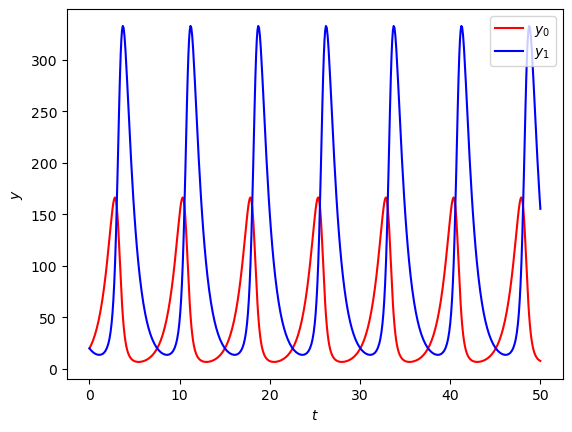

40 ms ± 947 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
# Test python
# 38.4ms
time_domain, y_results, success, message = nbrk_ode_py(y_diff, time_span, initial_conds, rtol=rtol, atol=atol)
diff_plot(time_domain, y_results)


%timeit nbrk_ode_py(y_diff, time_span, initial_conds, rtol=rtol, atol=atol)

C:\ProgramData\Anaconda3\envs\tpy39\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


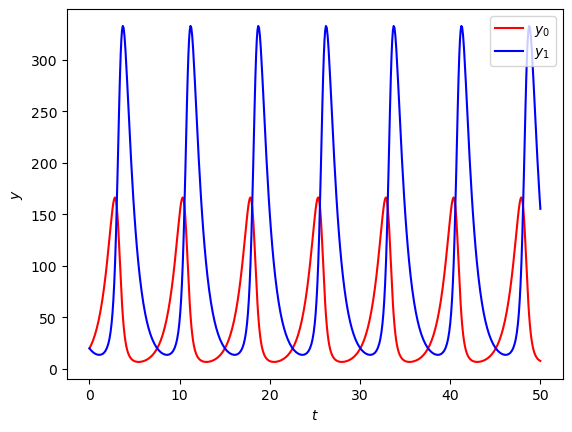

2.15 ms ± 43.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
# Test Numba - RK45
# 2.05ms
# >>0.2.3 1.93ms
time_domain, y_results, success, message = nbrk_ode(y_diff, time_span, initial_conds, rtol=rtol, atol=atol)
diff_plot(time_domain, y_results)

%timeit nbrk_ode(y_diff, time_span, initial_conds, rtol=rtol, atol=atol)

C:\ProgramData\Anaconda3\envs\tpy39\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


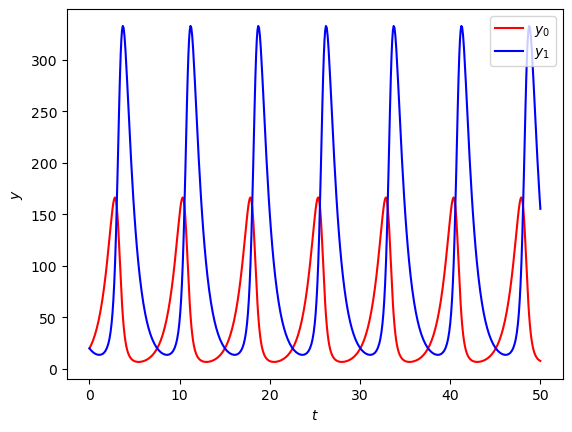

617 µs ± 5.39 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [40]:
# Test Numba - tester - RK45
# 2.05ms
# >>0.2.3 2.06ms
# >>0.3.0 0.946ms, 0.804ms, 0.629ms
time_domain, y_results, success, message = nbrk_ode_tester(y_diff, time_span, initial_conds, rtol=rtol, atol=atol)
diff_plot(time_domain, y_results)

%timeit nbrk_ode_tester(y_diff, time_span, initial_conds, rtol=rtol, atol=atol)

Integration finished with no issue.


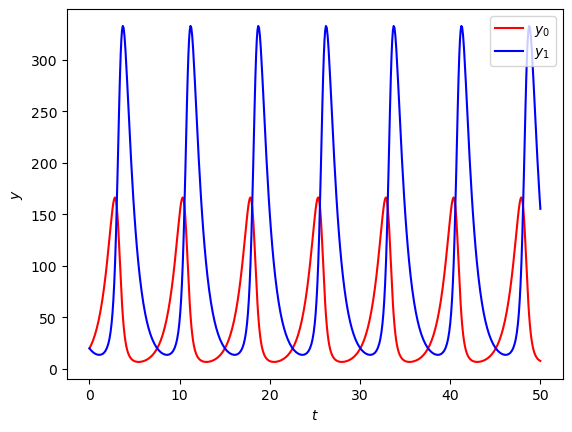

2.38 ms ± 149 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [55]:
# Test Cython - RK45

# 60ms
# 53.5ms
# 56.7ms, 56.1ms
# 56.8ms
# 47.8ms
# 36ms
# 35ms
# 26.9ms
# 26.6ms
# started adding mem views and it sucks now. 55ms
# 21.5ms
# 17.6ms
# 17ms
# 16.8ms
# 14.6ms
# 9.16ms
# 8.62ms
# 6.14ms
# 4.41ms
# 4.33ms
# 4.25ms
# 4.1ms
# 4.15ms
# 4.08ms
# 4.07ms
# 3.94ms
# 3.49ms
# 3.43ms
# 3.33ms
# 3.25ms
# 2.96ms
# 2.92ms
# 2.78ms
# 2.55ms
# 2.33ms
# 2.82ms  (added teval functionality)
# 2.61ms
# 2.73ms  (added DOP)
# 2.63ms
# 2.45ms
# 2.32ms
# >>0.2.3 2.42ms
# 2.4ms
# 2.31ms

time_domain, y_results, success, message = cyrk_ode(y_diff2, time_span, initial_conds,
                                                           rtol=rtol, atol=atol, rk_method=1)
print(message)
diff_plot(time_domain, y_results)

%timeit cyrk_ode(y_diff2, time_span, initial_conds, rtol=rtol, atol=atol, rk_method=1)

Integration finished with no issue.


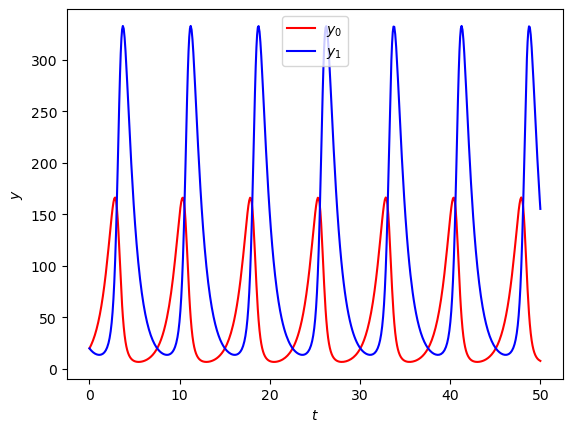

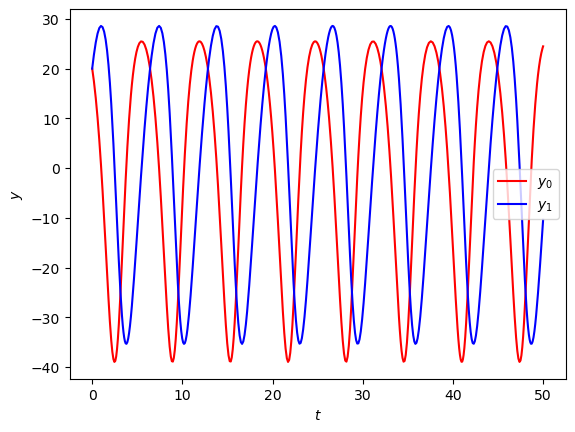

2.45 ms ± 2.58 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
# Cython with complex diffeq

time_domain, y_results, success, message = cyrk_ode(y_diff3, time_span, initial_conds3,
                                                           rtol=rtol, atol=atol, rk_method=1)
print(message)
diff_plot(time_domain, np.real(y_results))
diff_plot(time_domain, np.imag(y_results))

%timeit cyrk_ode(y_diff3, time_span, initial_conds3, rtol=rtol, atol=atol, rk_method=1)

Finished


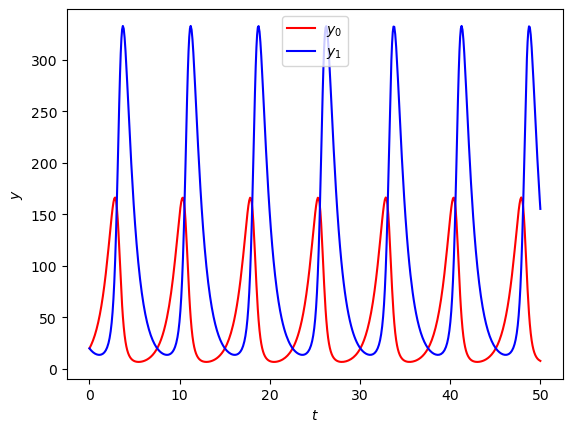

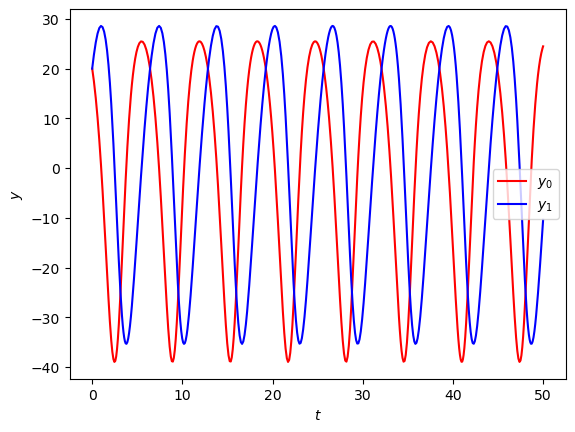

2.49 ms ± 68.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
# Numba with complex diffeq

time_domain, y_results, success, message = nbrk_ode_tester(y_diff4, time_span, initial_conds3,
                                                           rtol=rtol, atol=atol, rk_method=1)
print(message)
diff_plot(time_domain, np.real(y_results))
diff_plot(time_domain, np.imag(y_results))

%timeit cyrk_ode(y_diff3, time_span, initial_conds3, rtol=rtol, atol=atol, rk_method=1)

### Check DOP

C:\ProgramData\Anaconda3\envs\cyrk39e\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


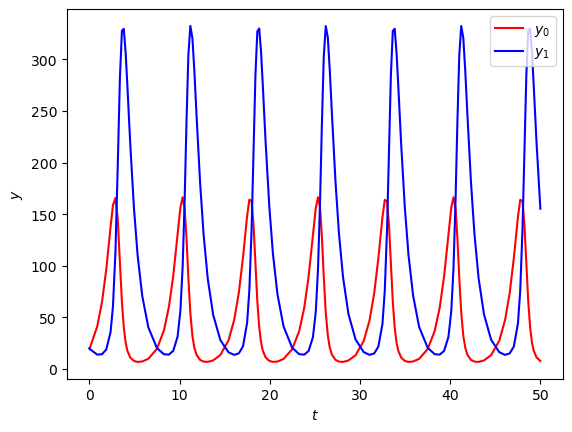

1.71 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [10]:
# Test Numba - DOP
# 1.78ms
time_domain, y_results, success, message = nbrk_ode(y_diff, time_span, initial_conds, rtol=rtol, atol=atol, rk_method=2)
diff_plot(time_domain, y_results)

%timeit nbrk_ode(y_diff, time_span, initial_conds, rtol=rtol, atol=atol, rk_method=2)

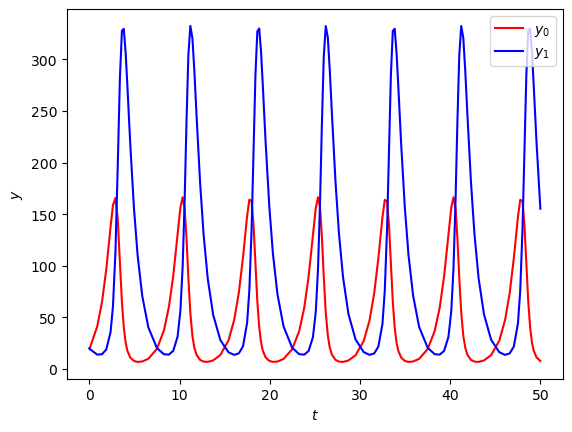

2.24 ms ± 13.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
# Test Cython - DOP
# 4ms
# 2.92ms
# 2.8ms
# 2.65ms
# 2.51ms


time_domain, y_results, success, message = cyrk_ode(y_diff2, time_span, initial_conds,
                                                           rtol=rtol, atol=atol, rk_method=2)
diff_plot(time_domain, y_results)

%timeit cyrk_ode(y_diff2, time_span, initial_conds, rtol=rtol, atol=atol, rk_method=2)

### Check t_eval

In [12]:
teval = np.linspace(0., time_span[1], 50)

C:\ProgramData\Anaconda3\envs\cyrk39e\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


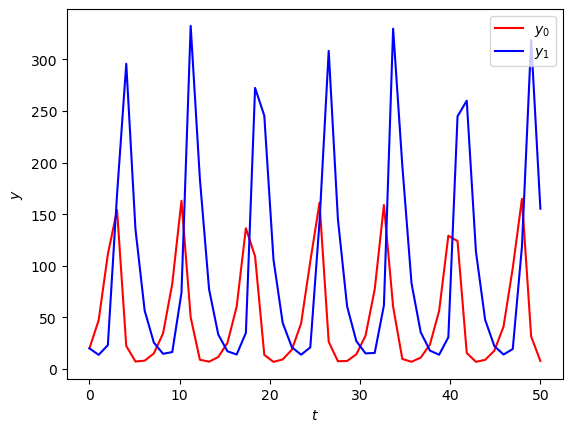

1.97 ms ± 8.36 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [13]:
# Test Numba - t_eval
time_domain, y_results, success, message = nbrk_ode(y_diff, time_span, initial_conds,
                                                           rtol=rtol, atol=atol, t_eval=teval)
diff_plot(time_domain, y_results)

%timeit nbrk_ode(y_diff, time_span, initial_conds, rtol=rtol, atol=atol, t_eval=teval)

Integration finished with no issue.


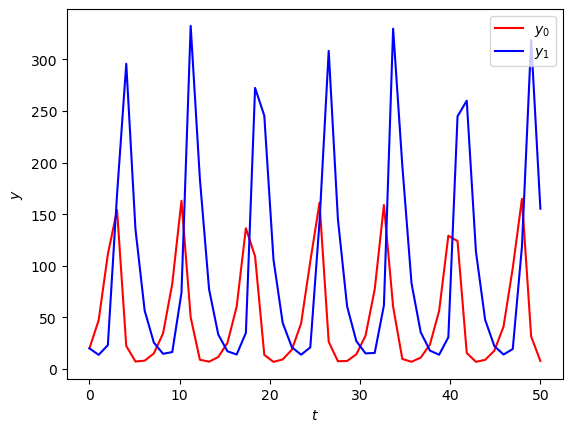

2.42 ms ± 18.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
# Test Cython - t_eval
# 2.74ms
time_domain, y_results, success, message = cyrk_ode(y_diff2, time_span, initial_conds,
                                                           rtol=rtol, atol=atol, t_eval=teval)
print(message)
diff_plot(time_domain, y_results)

%timeit cyrk_ode(y_diff2, time_span, initial_conds, rtol=rtol, atol=atol, t_eval=teval)

### Check larger t domain

In [36]:
time_span_2 = (0., 5000.)

C:\ProgramData\Anaconda3\envs\tpy39\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


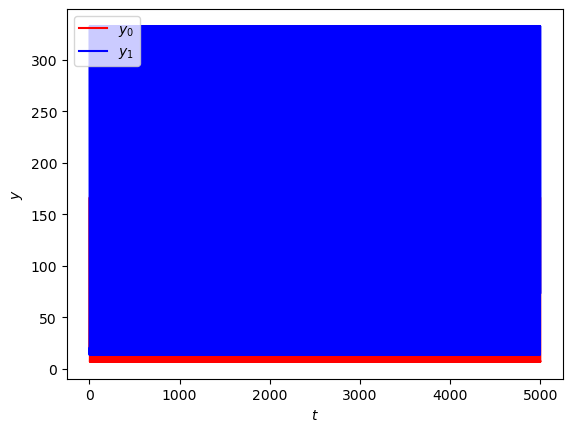

5.3 s ± 25.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
# Test python
# 5.3 s
time_domain, y_results, success, message = nbrk_ode_py(y_diff, time_span_2, initial_conds, rtol=rtol, atol=atol)
diff_plot(time_domain, y_results)

%timeit nbrk_ode_py(y_diff, time_span_2, initial_conds, rtol=rtol, atol=atol)

C:\ProgramData\Anaconda3\envs\tpy39\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


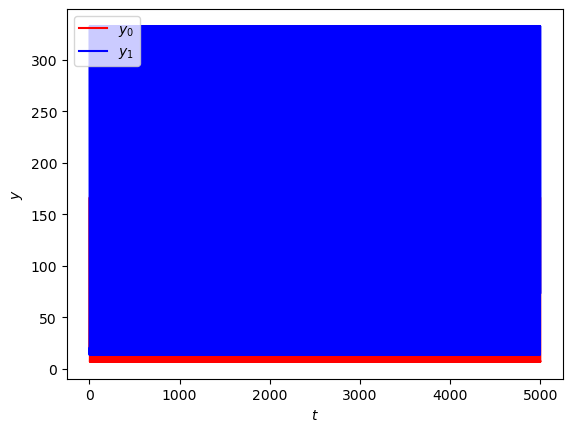

1.83 s ± 130 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
# Test Numba - RK45
# 1800 ms
# 2350 ms
# >>0.2.3 1.83 s
time_domain, y_results, success, message = nbrk_ode(y_diff, time_span_2, initial_conds, rtol=rtol, atol=atol)
diff_plot(time_domain, y_results)

%timeit nbrk_ode(y_diff, time_span_2, initial_conds, rtol=rtol, atol=atol)

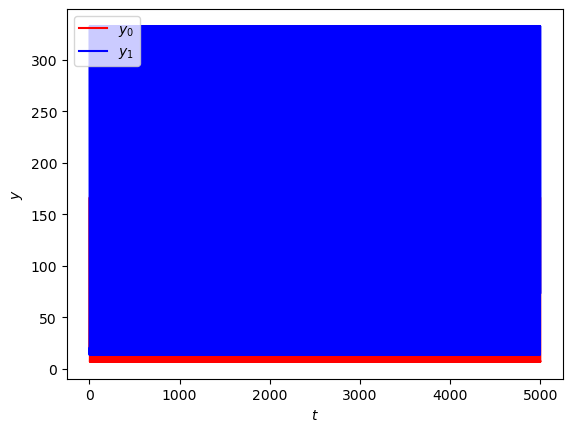

45.6 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
# Test Numba - tester - RK45
# 1800 ms
# 2350 ms
# >>0.2.3 1.83 s
# >>0.3.0 1.56 s, 1.46s, 1.41s, 1.42s, 45.6ms
time_domain, y_results, success, message = nbrk_ode_tester(y_diff, time_span_2, initial_conds, rtol=rtol, atol=atol)
diff_plot(time_domain, y_results)

%timeit nbrk_ode_tester(y_diff, time_span_2, initial_conds, rtol=rtol, atol=atol)

Integration finished with no issue.


C:\ProgramData\Anaconda3\envs\tpy39\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


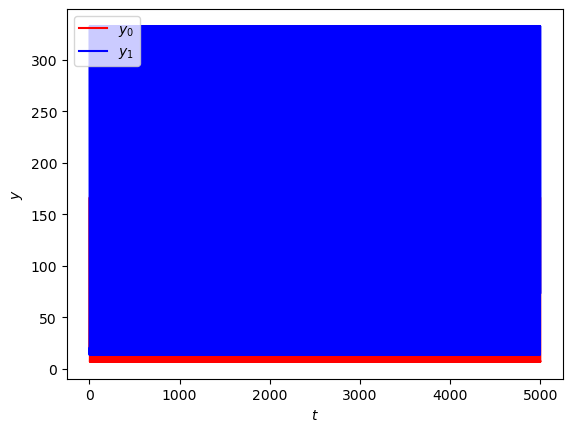

231 ms ± 6.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
# Test Cython - RK45
# 238 ms
# 229 ms
# >>0.2.3 0.231 s

time_domain, y_results, success, message = cyrk_ode(y_diff2, time_span_2, initial_conds,
                                                           rtol=rtol, atol=atol, rk_method=1)
print(message)
diff_plot(time_domain, y_results)

%timeit cyrk_ode(y_diff2, time_span_2, initial_conds, rtol=rtol, atol=atol, rk_method=1)

In [17]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [18]:
%lprun -f nbrk_ode_tester.py_func nbrk_ode_tester.py_func(y_diff, time_span_2, initial_conds, rtol=rtol, atol=atol)

In [8]:
%load_ext memory_profiler

In [11]:
from CyRK.nb.nbrk import nbrk_ode
%mprun -f nbrk_ode nbrk_ode.py_func(y_diff, time_span_2, initial_conds, rtol=rtol, atol=atol)